# Uso de Computer Vision para la detección de radiografías de Covid-19 frente a radiografías de pulmonía.

Réplica del ártículo https://arxiv.org/pdf/2003.12338.pdf.

Las imágenes con Covid son extraídas del siguiente repositorio de github: https://github.com/ieee8023/covid-chestxray-dataset.

Las imágenes con pulmonía y sin enfermedad son extraídas del dataset ChestX-Ray 14 que se encuentra en Kaggle https://www.kaggle.com/nih-chest-xrays/data.

El objetivo del notebook es la detección de radiografías de Covid19 frente a radiografías de pulmonía. Tenemos la opción de añadir 3000 radiografías sin enfermedad con el parámetro NORMAL.

In [1]:
import pandas as pd
import numpy as np
import argparse
import shutil
import random
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import gc

from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
NORMAL = True #fix use set normal or not
VAL = False #fix set validation
virus = "COVID-19" # Virus to look for
x_ray_view1 = "PA" # View of X-Ray
x_ray_view2 = "AP"
covid = "covid.csv" # Meta info
pulmonia = "datos_images_neumonia.csv"
normal = "datos_images_normal.csv"
imageDir = "images/" # Directory of images


In [3]:
def carga_csv(pulmonia = pulmonia, covid = covid, normal = normal):
    pulmonia_csv = pd.read_csv(pulmonia)   
    print(pulmonia_csv.shape)
    if NORMAL:
        normal_csv = pd.read_csv(normal)   
        print(normal_csv.shape)
    covid_csv = pd.read_csv(covid)   
    vista = np.where(covid_csv["view"] == x_ray_view1) + np.where(covid_csv["view"] == x_ray_view2)
    vista = np.append(vista[0],vista[1])
    covid_csv = covid_csv.iloc[vista] 
    covid_csv = covid_csv.loc[covid_csv["finding"]== virus]
    covid_csv.reset_index(inplace=True,drop=True)
    print(covid_csv.shape)
    if NORMAL:
        return pulmonia_csv, normal_csv, covid_csv
    else:
        return pulmonia_csv, covid_csv

In [4]:
if NORMAL:
    pulmonia_csv, normal_csv, covid_csv = carga_csv()
else:
    pulmonia_csv, covid_csv = carga_csv()

(1431, 10)
(3000, 15)
(172, 28)


In [5]:
print("Hay",len(covid_csv.patientid.unique()),"pacientes únicos con Covid.")
print("Hay",len(pulmonia_csv["Patient ID"].unique()),"pacientes únicos con pulmonía.")
if NORMAL:
    print("Hay",len(normal_csv["Patient ID"].unique()),"pacientes únicos sin enfermedad.")


Hay 120 pacientes únicos con Covid.
Hay 1008 pacientes únicos con pulmonía.
Hay 1174 pacientes únicos sin enfermedad.


# Carga y escalado de imágenes

+ Tenemos 120 pacientes con Covid y 149 radiografías de covid.
+ Tenemos imágenes a distintos tamaños. Existen unas pocas imágenes cuyo tamaño es debajo de 512. Son pocas, posible eliminación.
+ Algunas imágenes están a blanco y negro y otras a "color" (3 o 4 canales, según sea RGB o RGBA). Las pasamos a un solo canal.
+ Los píxeles están todos entre 0 y 255.

In [6]:
%%time
images_covid = []
tam = 512
for (i, row) in tqdm(covid_csv.iterrows()):
    filename = row["filename"].split(os.path.sep)[-1]
    path = imageDir+'/covid/'+filename
    img = Image.open(path)
    size = img.size
    if size[0]>=512 or size[1]>=512:
        if img.mode!='L':
            img = img.convert('L')
        img = img.resize((tam, tam))
        images_covid.append(img)
    else:
        covid_csv.drop([i], inplace=True)

print("Disponemos de",len(images_covid),"radriografías de Covid.")


Disponemos de 149 radriografías de Covid.
CPU times: user 9.12 s, sys: 352 ms, total: 9.47 s
Wall time: 12.8 s


In [7]:
%%time
images_pulmonia = []

tam = 512
for (i, row) in tqdm(pulmonia_csv.iterrows()):
    filename = row["Image Index"].split(os.path.sep)[-1]
    path = imageDir+'/neumonia/'+filename
    img = Image.open(path)
    size = img.size
    if size[0]>=512 or size[1]>=512:
        if img.mode!='L':
            img = img.convert('L')
        img = img.resize((tam, tam))
        images_pulmonia.append(img)
    else:
        pulmonia_csv.drop([i], inplace=True)

print("Disponemos de",len(images_pulmonia),"radriografías de pulmonía.")


Disponemos de 1431 radriografías de pulmonía.
CPU times: user 31.5 s, sys: 432 ms, total: 31.9 s
Wall time: 51.9 s


In [8]:
%%time
if NORMAL:
    images_normal = []

    tam = 512
    for (i, row) in tqdm(normal_csv.iterrows()):
        filename = row["Image Index"].split(os.path.sep)[-1]
        path = imageDir+'/normal/'+filename
        img = Image.open(path)
        size = img.size
        if size[0]>=512 or size[1]>=512:
            if img.mode!='L':
                img = img.convert('L')
            img = img.resize((tam, tam))
            images_normal.append(img)
        else:
            normal_csv.drop([i], inplace=True)

    print("Disponemos de",len(images_normal),"radriografías de pulmonía.")


Disponemos de 3000 radriografías de pulmonía.
CPU times: user 1min 7s, sys: 992 ms, total: 1min 8s
Wall time: 1min 54s


In [9]:
def escala(images):
    for i, j in tqdm(enumerate(images)):
        images[i] = np.array(j)/255
    return images

In [10]:
images_covid = escala(images_covid)
images_pulmonia = escala(images_pulmonia)
if NORMAL:
    images_normal = escala(images_normal)

# Muestro unas pocas radiografías

In [11]:
def ceildiv(a, b):
    return -(-a // b)
def plots_from_files(images_covid, sel, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    for ind, i in enumerate(sel):
        sp = f.add_subplot(rows, ceildiv(len(sel), rows), ind+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[ind], fontsize=16)
        #img = plt.imread(sel[i])
        plt.imshow(images_covid[i],cmap="bone")

## Covid

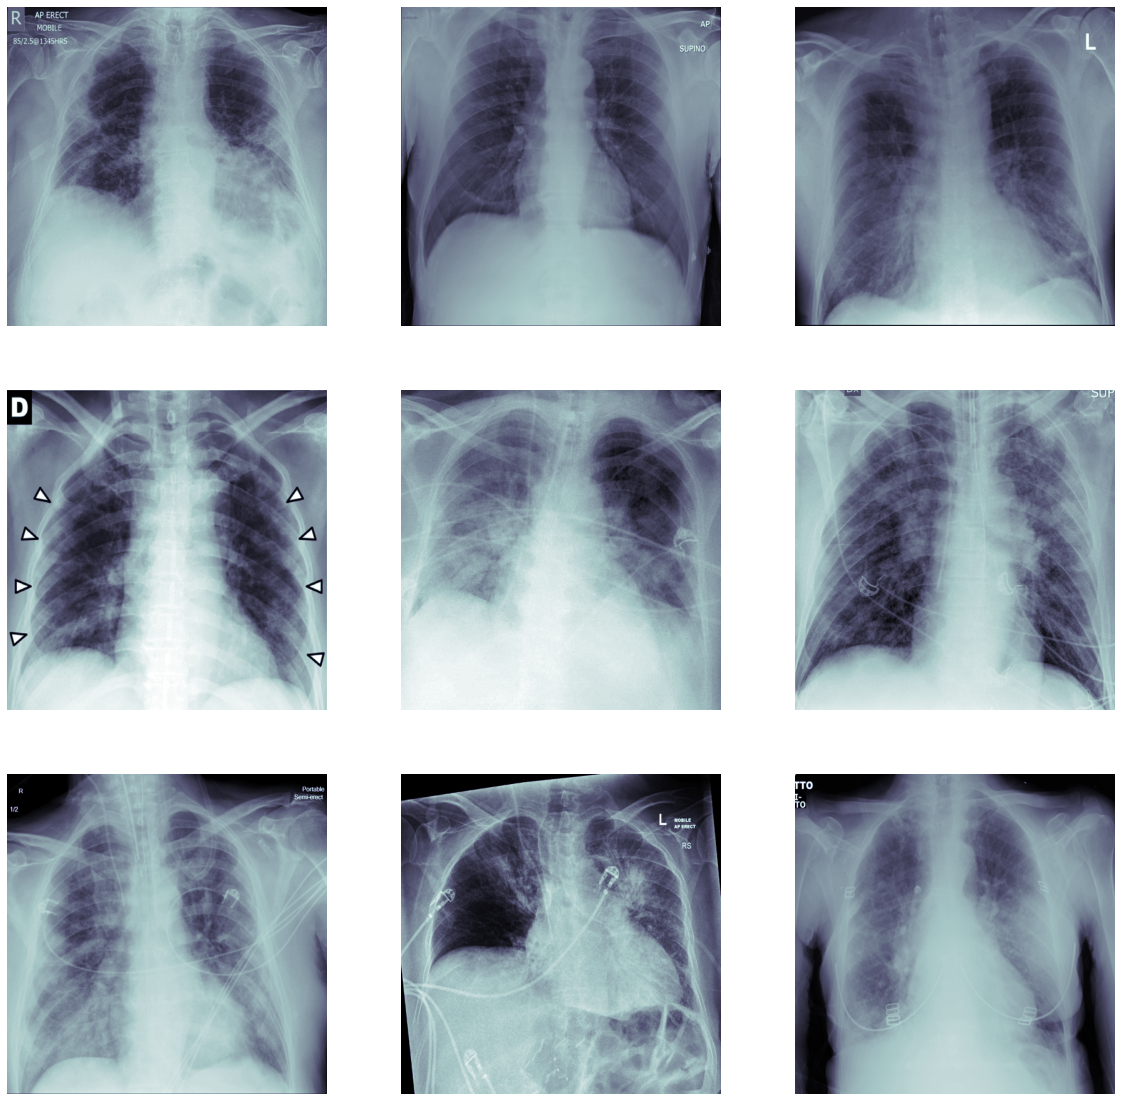

In [12]:
sel = np.random.choice(len(images_covid), size=9)
plots_from_files(images_covid, sel, rows=3, figsize=(20,20))

## Pulmonía

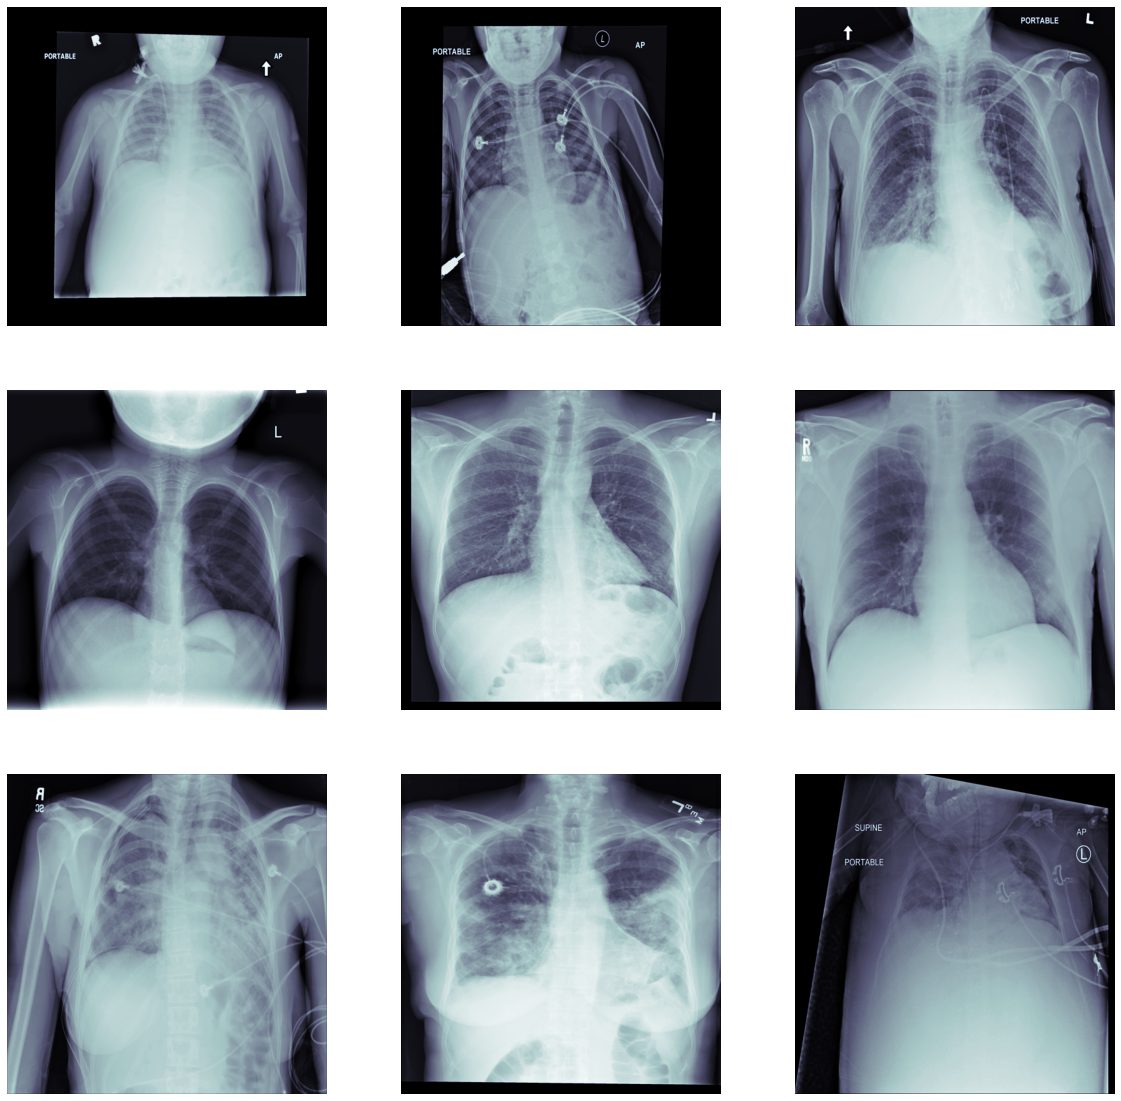

In [13]:
sel = np.random.choice(len(images_pulmonia), size=9)
plots_from_files(images_pulmonia, sel, rows=3, figsize=(20,20))

# NORMAL 

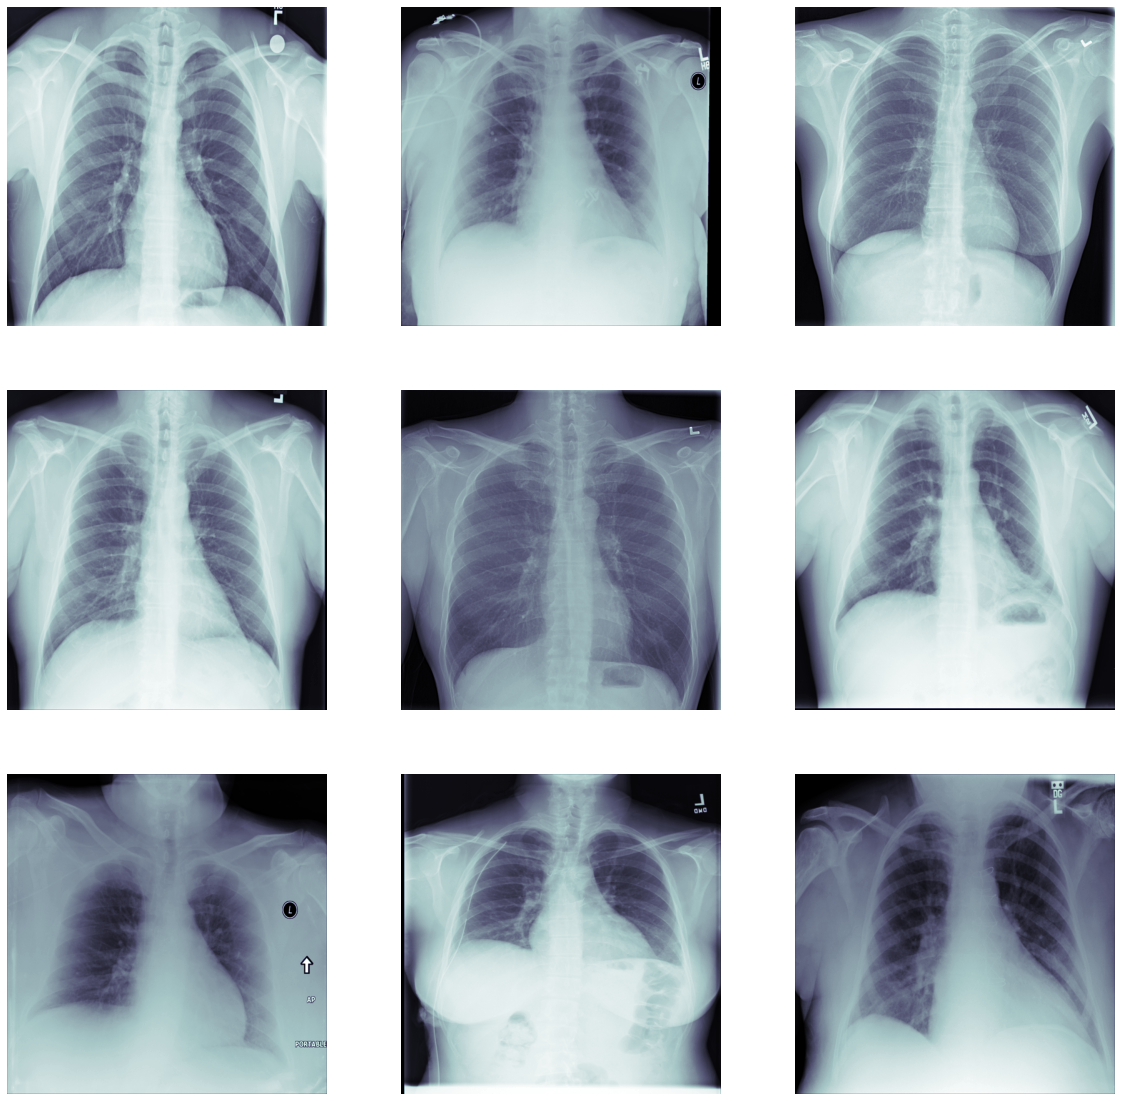

In [14]:
if NORMAL:
    sel = np.random.choice(len(images_normal), size=9)
    plots_from_files(images_normal, sel, rows=3, figsize=(20,20))

# Train/Val/Test y creación de labels

In [15]:
if VAL:
    test_size = 0.2
    val_size = 0.1
else:
    test_size = 0.3

In [16]:
Id_covid = covid_csv.patientid.values
Id_pulmonia = pulmonia_csv["Patient ID"].values
if NORMAL:
    Id_normal = normal_csv["Patient ID"].values

In [17]:
def particion_por_pacientes(IDs, val_size=0.1, test_size=0.2, random_state=1):
    aux = np.unique(IDs)
    aux_tr, aux_te = train_test_split(aux, test_size=test_size, random_state=random_state)
    aux_tr, aux_val = train_test_split(aux_tr, test_size=val_size, random_state=random_state+1)

    inds_tr = [i for i,x in enumerate(IDs) if x in aux_tr]
    inds_val = [i for i,x in enumerate(IDs) if x in aux_val]
    inds_te = [i for i,x in enumerate(IDs) if x in aux_te]

    return inds_tr,inds_val, inds_te

def particion_por_pacientes_sin_val(IDs, test_size=0.2, random_state=1):
    aux = np.unique(IDs)
    aux_tr, aux_te = train_test_split(aux, test_size=test_size, random_state=random_state)

    inds_tr = [i for i,x in enumerate(IDs) if x in aux_tr]
    inds_te = [i for i,x in enumerate(IDs) if x in aux_te]

    return inds_tr, inds_te

In [18]:
if VAL: 
    inds_train_covid, inds_val_covid, inds_test_covid = particion_por_pacientes(IDs = Id_covid, val_size = val_size, test_size = test_size, random_state = 1)
    inds_train_neumonia, inds_val_neumonia, inds_test_neumonia = particion_por_pacientes(IDs = Id_pulmonia, val_size = val_size, test_size = test_size, random_state = 3)
    if NORMAL:
        inds_train_normal, inds_val_normal, inds_test_normal = particion_por_pacientes(IDs = Id_normal, val_size = val_size, test_size = test_size, random_state = 5)

else:
    inds_train_covid, inds_test_covid = particion_por_pacientes_sin_val(IDs = Id_covid, test_size = test_size, random_state = 7)
    inds_train_neumonia, inds_test_neumonia = particion_por_pacientes_sin_val(IDs = Id_pulmonia, test_size = test_size, random_state = 9)
    if NORMAL: 
        inds_train_normal, inds_test_normal = particion_por_pacientes_sin_val(IDs = Id_normal, test_size = test_size, random_state = 11)


In [19]:
imagenes_train_covid  = [images_covid[ind] for ind in inds_train_covid]
imagenes_train_pulmonia  = [images_pulmonia[ind] for ind in inds_train_neumonia]
if NORMAL:
    imagenes_train_normal  = [images_normal[ind] for ind in inds_train_normal]
    imagenes_train = imagenes_train_covid + imagenes_train_pulmonia + imagenes_train_normal
    doses = np.ones(len(imagenes_train_normal)) + 1
else:
    imagenes_train = imagenes_train_covid + imagenes_train_pulmonia

unos = np.ones(len(imagenes_train_covid))
ceros = np.zeros(len(imagenes_train_pulmonia))
if NORMAL:
    y_train = unos.tolist() + ceros.tolist() + doses.tolist()
    del(imagenes_train_normal)
else:
    y_train = unos.tolist() + ceros.tolist()
del(imagenes_train_covid,imagenes_train_pulmonia)

if VAL:
    imagenes_val_covid  = [images_covid[ind] for ind in inds_val_covid]
    imagenes_val_pulmonia  = [images_pulmonia[ind] for ind in inds_val_neumonia]
    if NORMAL:
        imagenes_val_normal  = [images_normal[ind] for ind in inds_val_normal]
        imagenes_val = imagenes_val_covid + imagenes_val_pulmonia + imagenes_val_normal
        doses = np.ones(len(imagenes_val_normal)) + 1
    else:
        imagenes_val = imagenes_val_covid + imagenes_val_pulmonia

    unos = np.ones(len(imagenes_val_covid))
    ceros = np.zeros(len(imagenes_val_pulmonia))
    if NORMAL:
        y_val = unos.tolist() + ceros.tolist() + doses.tolist()
        del(imagenes_val_normal)
    else:
        y_val = unos.tolist() + ceros.tolist()
    del(imagenes_val_covid,imagenes_val_pulmonia)

imagenes_test_covid  = [images_covid[ind] for ind in inds_test_covid]
imagenes_test_pulmonia  = [images_pulmonia[ind] for ind in inds_test_neumonia]
if NORMAL:
    imagenes_test_normal  = [images_normal[ind] for ind in inds_test_normal]
    imagenes_test = imagenes_test_covid + imagenes_test_pulmonia + imagenes_test_normal
    doses = np.ones(len(imagenes_test_normal)) + 1
else:
    imagenes_test = imagenes_test_covid + imagenes_test_pulmonia

unos = np.ones(len(imagenes_test_covid))
ceros = np.zeros(len(imagenes_test_pulmonia))

if NORMAL:
    y_test = unos.tolist() + ceros.tolist() + doses.tolist()
    del(imagenes_test_normal)
else:
    y_test = unos.tolist() + ceros.tolist()
del(imagenes_test_covid,imagenes_test_pulmonia)
if NORMAL:
    del(images_normal)
del(images_covid, images_pulmonia)

In [20]:
def shuffle(images, y):
    mapIndexPosition = list(zip(images, y))
    random.shuffle(mapIndexPosition)
    images, y = zip(*mapIndexPosition)
    return images, y

In [21]:
imagenes_train, y_train = shuffle(imagenes_train, y_train)
if VAL:
    imagenes_val, y_val = shuffle(imagenes_val, y_val)
imagenes_test, y_test = shuffle(imagenes_test, y_test)

In [22]:
imagenes_train = np.expand_dims(imagenes_train, axis=3)
if VAL:
    imagenes_val = np.expand_dims(imagenes_val, axis=3)
imagenes_test  = np.expand_dims(imagenes_test, axis=3)
print("Shape train", imagenes_train.shape)
if VAL:
    print("Shape val", imagenes_val.shape)
print("Shape test", imagenes_test.shape)

Shape train (3281, 512, 512, 1)
Shape test (1299, 512, 512, 1)


# Class weights

In [23]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights1 = {0.: class_weights[0] ,1.:class_weights[1]}
print("Class weights:",class_weights)

Class weights: [ 1.07856673 10.82838284  0.50492459]


# Convertimos el target en [0,1] o [1,0]



Esto lo hacemos para poder utilizar una softmax de capa de salida y finalmente mirar heatmaps respecto a cada clase.

In [24]:
y_train = np.array(y_train)
if VAL:
    y_val = np.array(y_val)
y_test = np.array(y_test)

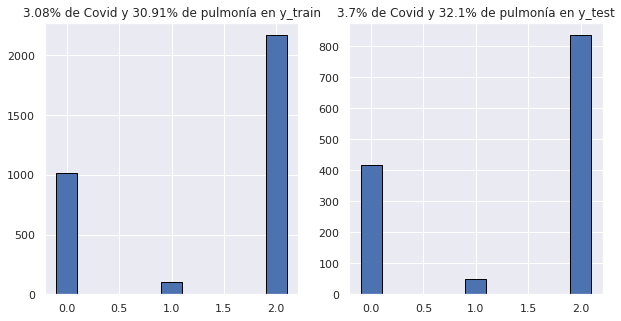

In [25]:
fig = plt.figure(figsize=(10,5))
if VAL:
    gs=GridSpec(1,3)
    l = [y_train, y_val, y_test]
    title = ["y_train", "y_val", "y_test"]
else:
    gs=GridSpec(1,2)
    l = [y_train, y_test]
    title = ["y_train", "y_test"]

sns.set(color_codes=True)
    
for i, x in enumerate(l):
    f_ax1 = fig.add_subplot(gs[0, i]) #posición de la gráfica

    plt.grid(color='w', linestyle='solid')

    dif_maxmin=x.max()-x.min()
    if NORMAL:
        bins=[x.min()-0.1,x.min()+0.1,x.min()-0.1+1,x.min()+0.1+1, x.max()-0.1,x.max()+0.1]
        pct = [round(len(x[x==1])/len(x)*100,2), round(len(x[x==0])/len(x)*100,2)]

        plt.title(str(pct[0])+"% de Covid y "+str(pct[1])+"% de pulmonía en " +title[i])
        

    else:
        pct = round((sum(x)/len(x))*100,2)
        plt.title(str(pct)+"% de Covid en " +title[i])
        bins=[x.min()-0.1,x.min()+0.1,x.max()-0.1,x.max()+0.1]
    N, bins, patches=f_ax1.hist(x, bins=bins, edgecolor='black')
plt.show()
del(l)

In [26]:
if NORMAL:
    y_train = np.eye(3)[y_train.astype(int)]
    if VAL:
        y_val =np.eye(3)[y_val.astype(int)]
    y_test  = np.eye(3)[y_test.astype(int)]
    print("Shape y_train", y_train.shape)
    if VAL:
        print("Shape y_val", y_val.shape)
    print("Shape y_test", y_test.shape)
    
else:
    y_train = np.hstack((1-y_train.reshape(-1,1), y_train.reshape(-1,1)))
    if VAL:
        y_val = np.hstack((1-y_val.reshape(-1,1), y_val.reshape(-1,1)))
    y_test  = np.hstack((1-y_test.reshape(-1,1),  y_test.reshape(-1,1)))
    print("Shape y_train", y_train.shape)
    if VAL:
        print("Shape y_val", y_val.shape)
    print("Shape y_test", y_test.shape)

Shape y_train (3281, 3)
Shape y_test (1299, 3)


#  Si queremos usar Data Augmentacion

De momento solo vamos a usar la opción Flip. Siguientes opciones son rotación hasta 20 grados y zoom con crooped.

In [27]:
datagen = ImageDataGenerator(horizontal_flip=True)
datagen.fit(imagenes_train)

# Modelo

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, Input, Concatenate, BatchNormalization)
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.models import Model

Using TensorFlow backend.


In [29]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.mobilenet import MobileNet

inp=(512,512,3)
input_shape = imagenes_train.shape[1:]
img_input = Input(shape=input_shape)
img_conc = Concatenate()([img_input, img_input, img_input])  
base_model = DenseNet121(include_top=False, input_tensor=img_conc, input_shape=inp, classes=2,pooling="avg", weights="imagenet")#, weights='imagenet'
x = base_model.output
x = Dense(100)(x)
x = Dropout(0.3)(x)
if NORMAL:
    predictions = Dense(3, activation='softmax', name="predictions")(x)
else:
    predictions = Dense(2, activation='softmax', name="predictions")(x)
model = Model(inputs=img_input, outputs=predictions)

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 512, 512, 3)  0           input_1[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 513, 513, 3)  0           concatenate[0][0]                
______________________________________________________________________________________________

In [30]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
learning_rate = 0.001
decay_rate =  0.005
optimizer = Adam(lr=learning_rate, decay=decay_rate)
if NORMAL:
    model.compile(optimizer=optimizer, loss="categorical_crossentropy",metrics= ['categorical_accuracy'])
else:
    model.compile(optimizer=optimizer, loss="categorical_crossentropy",metrics= ['binary_accuracy'])

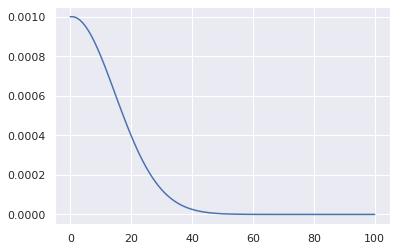

In [31]:
learning_rate = 0.001
decay_rate =  0.005
l=[learning_rate]
lr=learning_rate
for i in range(100):
    lr=lr/(1+(i*decay_rate))
    l.append(lr)
plt.plot(l)
plt.show()

In [32]:
acum_tr_acc   = []
acum_val_acc  = []
acum_tr_loss  = []
acum_val_loss = []
best_val_acc = -1e50
best_epoch = 0
epoca = 0

In [33]:
sns.set_style("white")

In [34]:
from matplotlib.ticker import MaxNLocator
from IPython.display import clear_output
import matplotlib.pyplot as plt
def grafica_entrenamiento(tr_acc=[], val_acc=[], tr_loss=[], val_loss=[], best_epoch=0,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    if len(val_acc)>0:
        ax = plt.subplot(1,2,1)
        plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
        plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
        plt.plot(1+best_epoch, 100*val_acc[best_epoch], 'or')
        plt.title('tasa de acierto del modelo (%)', fontsize=18)
        plt.ylabel('tasa de acierto (%)', fontsize=18)
        plt.xlabel('época', fontsize=18)
        plt.legend(['entrenamiento', 'validación'], loc='upper left')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax = plt.subplot(1,2,2)
    else:
        ax = plt.subplot(1,1,1)
    
    plt.plot(1+np.arange(len(tr_loss)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_loss)), np.array(val_loss))
    plt.plot(1+best_epoch, val_loss[best_epoch], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [35]:
from matplotlib.ticker import MaxNLocator
from IPython.display import clear_output
import matplotlib.pyplot as plt
def grafica_entrenamiento_only_train(tr_acc=[], tr_loss=[], best_epoch=0,figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+best_epoch, 100*tr_acc[best_epoch], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax = plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_loss)), np.array(tr_loss))
    plt.plot(1+best_epoch, tr_loss[best_epoch], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

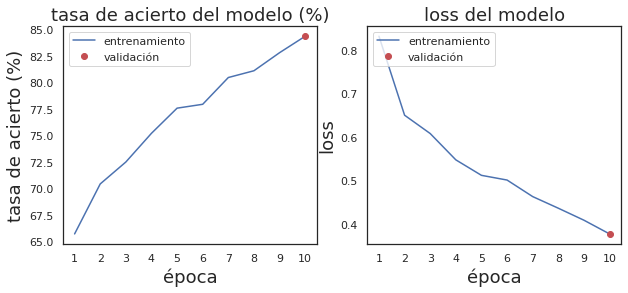

In [36]:
epochs = 10
batch_size = 16
for i in range(epochs):
    #history = model.fit(imagenes_train,y_train, batch_size=batch_size,verbose=1, epochs=1,validation_data=(imagenes_val,y_val),class_weight=class_weights)
    if VAL: 
        history = model.fit_generator(datagen.flow(imagenes_train, y_train, batch_size=batch_size), steps_per_epoch=len(imagenes_train) / (batch_size),verbose=1, epochs=1,validation_data=(imagenes_val,y_val),class_weight=class_weights)
    else: 
        history = model.fit_generator(datagen.flow(imagenes_train, y_train, batch_size=batch_size), steps_per_epoch=len(imagenes_train) / (batch_size),verbose=1, epochs=1,class_weight=class_weights)
    
    if NORMAL:
        acum_tr_acc.append(history.history['categorical_accuracy'][-1])
    else:
        acum_tr_acc.append(history.history['binary_accuracy'][-1])
    acum_tr_loss.append(history.history['loss'][-1])
    
    if VAL:
        if NORMAL:
            acum_val_acc.append(history.history['categorical_accuracy'][-1])
        else:
            acum_val_acc.append(history.history['val_binary_accuracy'][-1])
        acum_val_loss.append(history.history['val_loss'][-1])

    if len(acum_tr_acc) > 1:
        if VAL:
            if acum_val_acc[-1] > best_val_acc:
                best_epoch = epoca
                best_val_acc = acum_val_acc[-1]
            clear_output()
            grafica_entrenamiento(acum_tr_acc, acum_val_acc,
                          acum_tr_loss, acum_val_loss, best_epoch)
                
        else:
            if acum_tr_acc[-1] > best_val_acc:
                best_epoch = epoca
                best_val_acc = acum_tr_acc[-1]
            clear_output()
            grafica_entrenamiento_only_train(acum_tr_acc, acum_tr_loss, best_epoch)
    epoca = epoca + 1
    gc.collect()

In [37]:
score_te = model.evaluate(imagenes_test, y_test)
print('Test loss     :', score_te[0])
print('Test accuracy :', score_te[1])

1299/1299 [==============================] - 31s 24ms/sample - loss: 0.5810 - categorical_accuracy: 0.7259
Test loss     : 0.5810358596820846
Test accuracy : 0.725943


In [38]:
y_train_prob_pred = model.predict(imagenes_train)
if VAL:
    y_val_prob_pred = model.predict(imagenes_val)
y_test_prob_pred = model.predict(imagenes_test)

In [39]:
def matrices_confusion(prob, true , ind = 1):
    if ind==0:
        print("PULMONÍA")
    if ind==1:
        print("COVID")
    if ind==2:
        print("NORMAL")
    for threshold in np.arange(0,1,0.1):    
        y_pred = 1*(prob[:, ind]>threshold)
        print("threshold: ",round(threshold,1),"accuracy: ",round(accuracy_score(true[:, ind], y_pred),3))
        print(confusion_matrix(true[:, ind], y_pred))

    
def roc(prob, true, epochs = epochs, ind = 1):
    fpr, tpr, thresholds = roc_curve(true[:,ind], prob[:,ind])
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(fpr, tpr, 'r-.', label = str(epochs) + ' epochs (%2.2f)' % auc(fpr, tpr))
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
    if ind==0:
        titulo = "PULMONÍA"
    if ind==1:
        titulo = "COVID"
    if ind==2:
        titulo = "NORMAL"
    plt.title("ROC de "+titulo)

    ax1.legend();

# Train

In [40]:
matrices_confusion(y_train_prob_pred, y_train)
if NORMAL:
    matrices_confusion(y_train_prob_pred, y_train,0)
    matrices_confusion(y_train_prob_pred, y_train,2)


COVID
threshold:  0.0 accuracy:  0.031
[[   0 3180]
 [   0  101]]
threshold:  0.1 accuracy:  0.99
[[3149   31]
 [   1  100]]
threshold:  0.2 accuracy:  0.995
[[3166   14]
 [   2   99]]
threshold:  0.3 accuracy:  0.997
[[3173    7]
 [   4   97]]
threshold:  0.4 accuracy:  0.998
[[3176    4]
 [   4   97]]
threshold:  0.5 accuracy:  0.998
[[3178    2]
 [   5   96]]
threshold:  0.6 accuracy:  0.998
[[3179    1]
 [   5   96]]
threshold:  0.7 accuracy:  0.998
[[3180    0]
 [   8   93]]
threshold:  0.8 accuracy:  0.997
[[3180    0]
 [  11   90]]
threshold:  0.9 accuracy:  0.996
[[3180    0]
 [  14   87]]
PULMONÍA
threshold:  0.0 accuracy:  0.309
[[   0 2267]
 [   0 1014]]
threshold:  0.1 accuracy:  0.477
[[ 555 1712]
 [   3 1011]]
threshold:  0.2 accuracy:  0.619
[[1028 1239]
 [  12 1002]]
threshold:  0.3 accuracy:  0.722
[[1383  884]
 [  29  985]]
threshold:  0.4 accuracy:  0.806
[[1691  576]
 [  60  954]]
threshold:  0.5 accuracy:  0.853
[[1888  379]
 [ 103  911]]
threshold:  0.6 accuracy: 

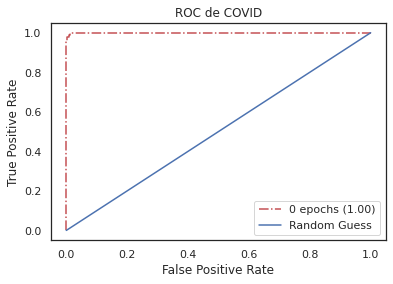

In [41]:
roc(y_train_prob_pred, y_train,0)


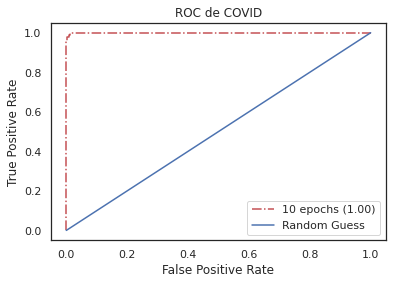

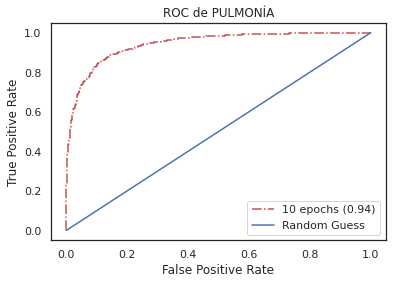

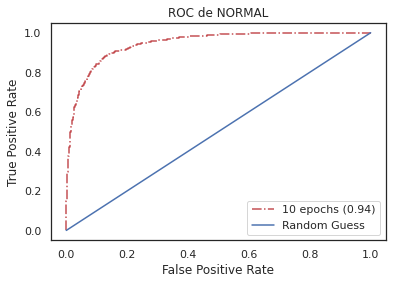

In [42]:
roc(y_train_prob_pred, y_train)
if NORMAL:
    roc(y_train_prob_pred, y_train, epochs, 0)
    roc(y_train_prob_pred, y_train, epochs, 2)


# Val

In [43]:
if VAL: 
    matrices_confusion(y_val_prob_pred, y_val)
    if NORMAL:
        matrices_confusion(y_val_prob_pred, y_val, 0)
        matrices_confusion(y_val_prob_pred, y_val, 2)


In [44]:
if VAL: 
    roc(y_val_prob_pred, y_val)
    if NORMAL:
        roc(y_val_prob_pred, y_val, epochs, 0)
        roc(y_val_prob_pred, y_val, epochs, 2)


# Test

In [45]:
matrices_confusion(y_test_prob_pred, y_test)
if NORMAL:
    matrices_confusion(y_test_prob_pred, y_test,0)
    matrices_confusion(y_test_prob_pred, y_test,2)

COVID
threshold:  0.0 accuracy:  0.037
[[   0 1251]
 [   0   48]]
threshold:  0.1 accuracy:  0.991
[[1242    9]
 [   3   45]]
threshold:  0.2 accuracy:  0.992
[[1245    6]
 [   4   44]]
threshold:  0.3 accuracy:  0.992
[[1246    5]
 [   5   43]]
threshold:  0.4 accuracy:  0.993
[[1249    2]
 [   7   41]]
threshold:  0.5 accuracy:  0.992
[[1249    2]
 [   8   40]]
threshold:  0.6 accuracy:  0.992
[[1249    2]
 [   8   40]]
threshold:  0.7 accuracy:  0.991
[[1250    1]
 [  11   37]]
threshold:  0.8 accuracy:  0.99
[[1251    0]
 [  13   35]]
threshold:  0.9 accuracy:  0.987
[[1251    0]
 [  17   31]]
PULMONÍA
threshold:  0.0 accuracy:  0.321
[[  0 882]
 [  0 417]]
threshold:  0.1 accuracy:  0.432
[[157 725]
 [ 13 404]]
threshold:  0.2 accuracy:  0.545
[[317 565]
 [ 26 391]]
threshold:  0.3 accuracy:  0.625
[[451 431]
 [ 56 361]]
threshold:  0.4 accuracy:  0.688
[[566 316]
 [ 89 328]]
threshold:  0.5 accuracy:  0.727
[[649 233]
 [122 295]]
threshold:  0.6 accuracy:  0.751
[[713 169]
 [155 

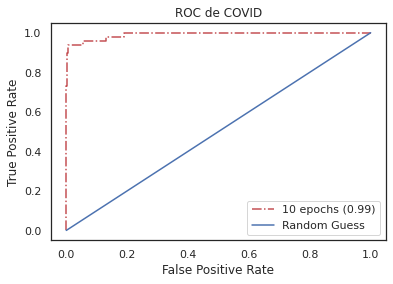

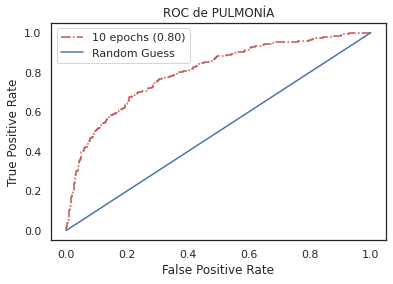

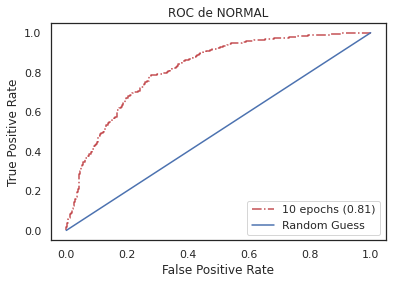

In [46]:
roc(y_test_prob_pred, y_test)
if NORMAL:
    roc(y_test_prob_pred, y_test, epochs, 0)
    roc(y_test_prob_pred, y_test, epochs, 2)

# Heatmaps 

In [49]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 512, 512, 3)  0           input_1[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0           concatenate[0][0]                
______________________________________________________________________________________________

In [52]:
import random
%matplotlib inline
from tensorflow.keras import backend as k
from PIL import Image
from numpy import zeros, newaxis
import cv2
from cv2 import imshow
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import MinMaxScaler
layer= -8#-6 
tam_capa= 1024 #1024
last_conv_layer = model.layers[layer]
eps = 0.00000001
gradModel = Model(
    inputs=[model.inputs],
    outputs= [last_conv_layer.output,
    model.output])
    
def heatmaps(i):
    gs=GridSpec(1,3)
    
    
    
    fig = plt.figure(figsize=(10,10))
    f_ax1 = fig.add_subplot(gs[0, 0])
    f_ax2 = fig.add_subplot(gs[0, 1])

    class_idx = np.argmax(y_test_prob_pred[i], axis=-1)
    #class_output = model.output[:, class_idx]
    class_output = model.output[:, np.int(y_test[i][1])]
    img = imagenes_test[i]
    dimen=(1,)+img.shape
    img = img.copy()
    img = img.reshape(dimen)
    x = [img]
    
    
    with tf.GradientTape() as tape:
        # cast the image tensor to a float-32 data type, pass the
        # image through the gradient model, and grab the loss
        # associated with the specific class index
        inputs = tf.cast(x[0], tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:, class_idx]
    # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]

    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    
    (w, h) = (img.shape[2], img.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    # return the resulting heatmap to the calling function
    
    colormap=cv2.COLORMAP_JET
    # apply the supplied color map to the heatmap and then
    # overlay the heatmap on the input image
    heatmap = cv2.applyColorMap(heatmap, colormap)
   
    img = np.repeat(img,3)
    img = img.reshape(512,512,3)
    img = (img * 255).astype("uint8")

    alpha=0.8
    superimposed_img = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)
    # return a 2-tuple of the color mapped heatmap and the output,
    # overlaid image
   #grads = tf.gradients(class_output, last_conv_layer.output)[0]
   #pooled_grads = k.mean(grads, axis=(0, 1, 2))
   #iterate = k.function([model.input], [pooled_grads, last_conv_layer.output[0]])
   #pooled_grads_value, conv_layer_output_value = iterate([x])
   #for j in range(tam_capa):
   #    conv_layer_output_value[:, :, j] *= pooled_grads_value[j]
   #heatmap = np.mean(conv_layer_output_value, axis=-1)
   #heatmap = np.maximum(heatmap, 0)
   #heatmap /= np.max(heatmap)
   #minmax=MinMaxScaler()
   #img = np.repeat(img,3)
   #img = img.reshape(512,512,3)
   #
   #heatmap = cv2.resize(heatmap, (img.shape[0], img.shape[1]))
   #heatmap = np.uint8(255 * heatmap)
   #img = np.uint8(255 * img)
   #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
   #superimposed_img = cv2.addWeighted(img, 0.7, heatmap, 0.3, 0)
    plt.title("Clase "+str(int(y_test[i,1]))+". Predict "+str(y_test_prob_pred[i]))
    #a = np.uint8(255 * imagenes_test[i].reshape(224,224))
    f_ax1.imshow(img,cmap='bone')
    f_ax2.imshow(superimposed_img)

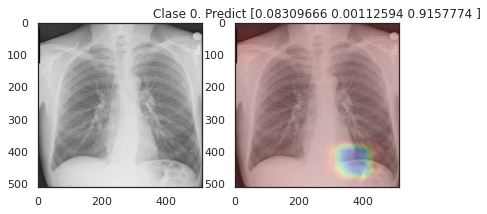

In [53]:
heatmaps(0)

In [54]:
covid=np.where(y_test[:,1]==1)
covid=np.array(covid)
covid=covid.tolist()
covid=covid[0]
normal=np.where(y_test[:,2]==1)
normal=np.array(normal)
normal=normal.tolist()
normal=normal[0]
pulmonia=np.where(y_test[:,0]==1)
pulmonia=np.array(pulmonia)
pulmonia=pulmonia.tolist()
pulmonia=pulmonia[0]

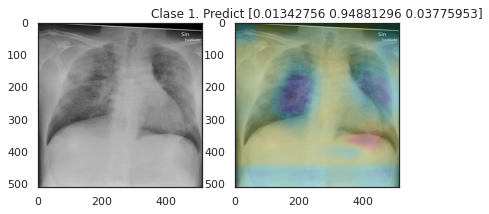

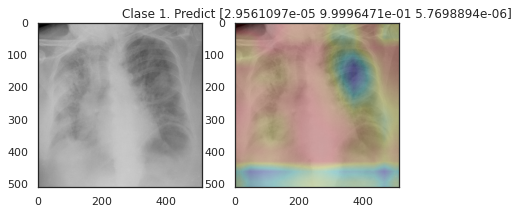

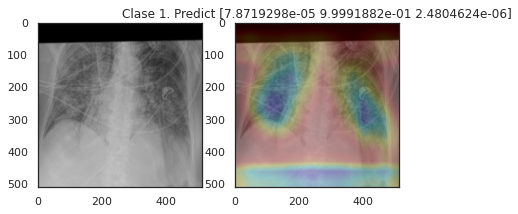

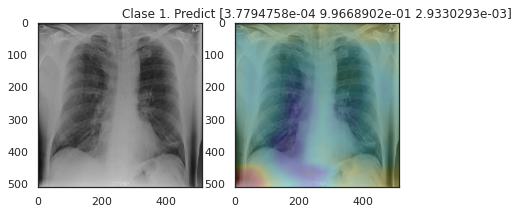

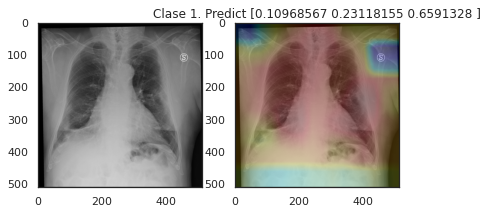

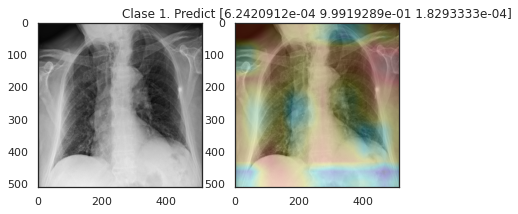

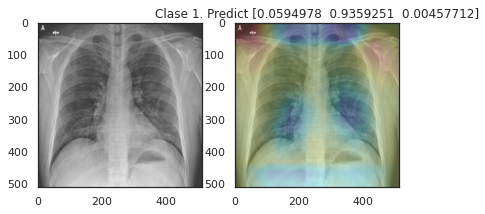

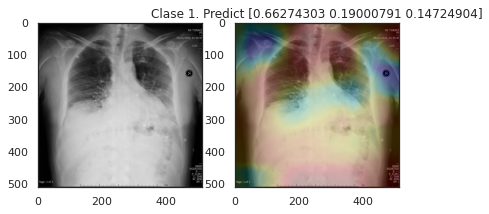

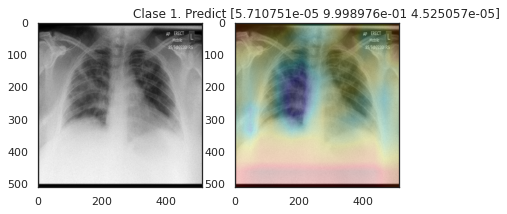

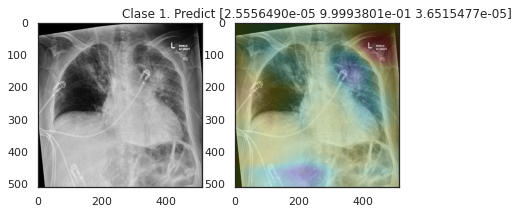

In [55]:
for i in covid[:10]:
    heatmaps(i)

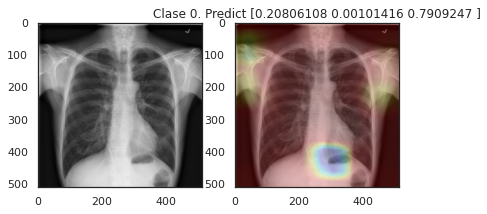

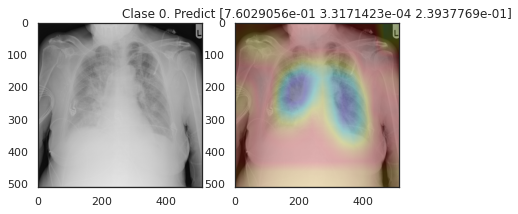

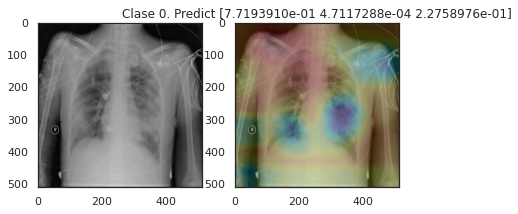

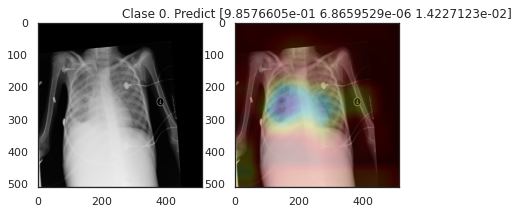

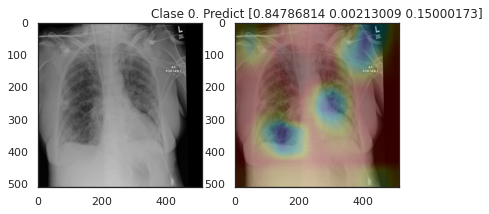

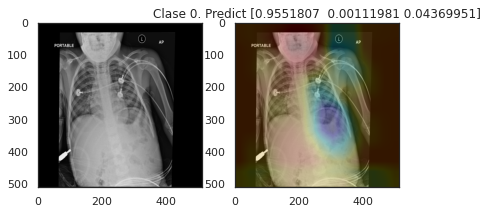

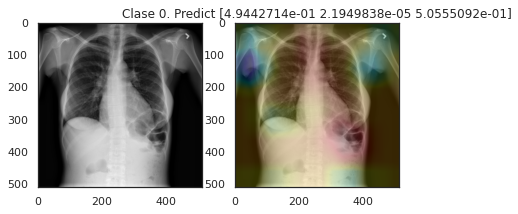

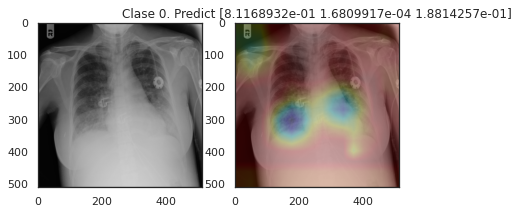

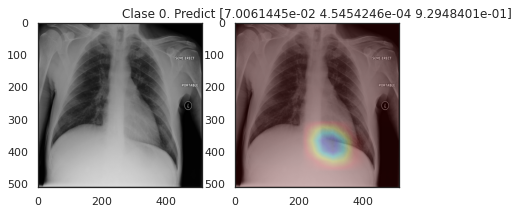

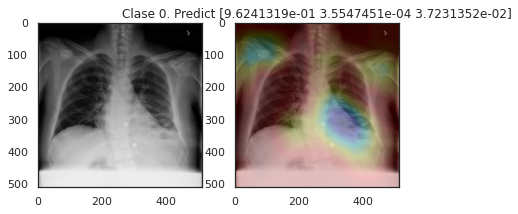

In [56]:
for i in pulmonia[:10]:
    heatmaps(i)

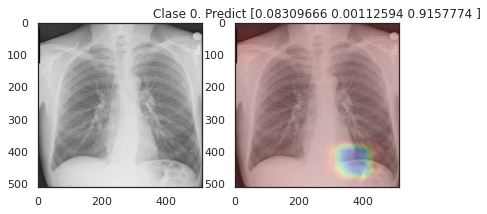

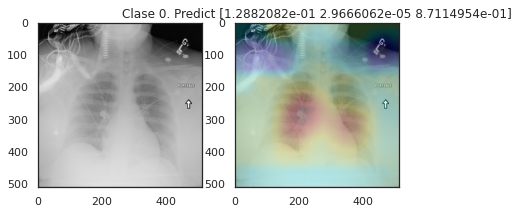

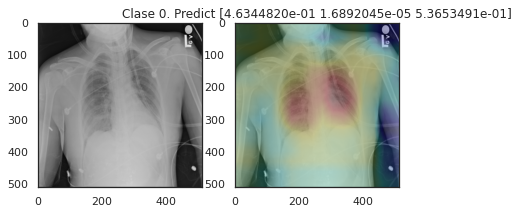

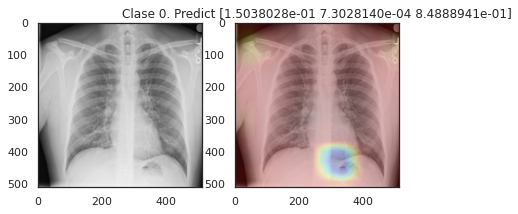

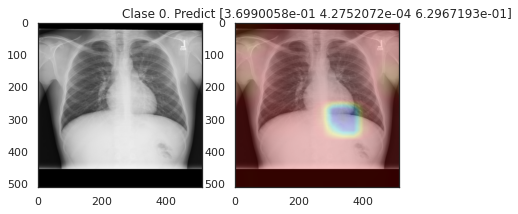

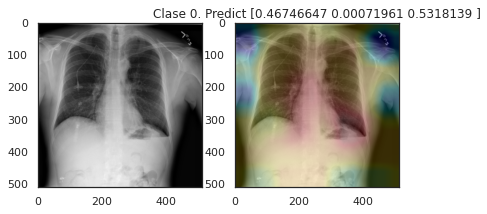

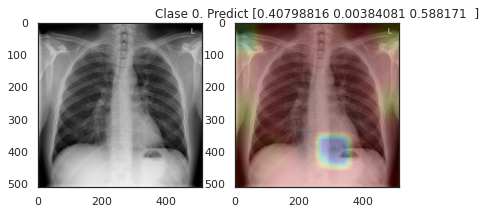

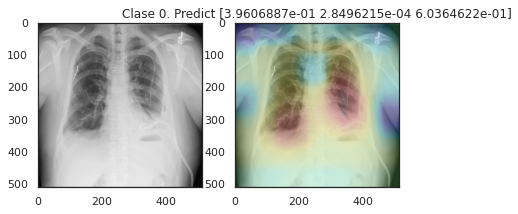

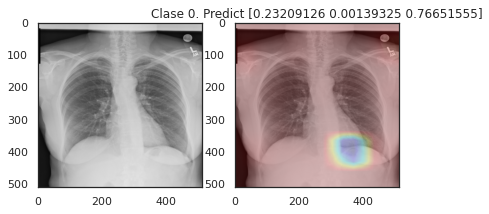

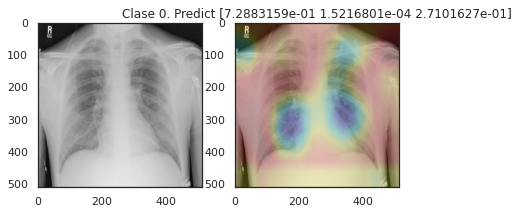

In [57]:
for i in normal[:10]:
    heatmaps(i)